# Семинар 6. Основы работы с библиотеками scanpy и Seurat

Это практикум с анализом данных scRNA-Seq. Он основан на пакете scanpy для Python 3 и Seurat для R версии 4 и больше.

In [ ]:
# Загрузка R magic
!pip install rpy2==3.5.1

# Установка нужных пакетов
!apt-get install libgmp3-dev libcairo2-dev libharfbuzz-dev libfribidi-dev libudunits2-dev
!pip install --upgrade --no-cache-dir gdown
!gdown 1W0TuuQospxcasOX5cQdhT_Xd-k7-QAck
!tar xf library.tar.gz
!pip3 install scanpy[leiden] anndata2ri

# Необходимо, чтобы конкретно прогрузился matplotlib
import os
os.kill(os.getpid(), 9)

%load_ext rpy2.ipython

In [4]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython
%R .libPaths("usr/local/lib/R/site-library/")

'/content/...,'/usr/loca...,'/usr/lib/...,'/usr/lib/...


Давайте для начала скачаем и распакуем архив с аутпутом программы Cell Ranger (без файла выравнивания, для уменьшения объёма). Он лежит в Google Colab со следующим ID: `1qmMBM0gt3EO9Gk30Weo11Sriy3wuZmUM` — и может быть загружен при помощи gdown:

In [5]:
!gdown 1Ctq4EmV2ps1dMiFcbqW467ywezRSGGN0
!unzip PBMC_10k.zip

Downloading...
From: https://drive.google.com/uc?id=1Ctq4EmV2ps1dMiFcbqW467ywezRSGGN0
To: /content/PBMC_10k.zip
100% 345M/345M [00:02<00:00, 119MB/s]
Archive:  PBMC_10k.zip
  inflating: filtered_feature_bc_matrix.h5  
  inflating: filtered_feature_bc_matrix.tar.gz  
  inflating: metrics_summary.csv     
  inflating: raw_feature_bc_matrix.h5  
  inflating: raw_feature_bc_matrix.tar.gz  
  inflating: web_summary.html        


Мы видим четыре файла: архив с нефильтрованной матрицей экспрессий, архив с отфильтрованными клетками, а также .html-отчёт о качестве выравнивания и его текстовая версия. Разархивируем отфильтрованные матрицы экспрессий.

In [6]:
!tar -xvzf filtered_feature_bc_matrix.tar.gz

filtered_feature_bc_matrix/
filtered_feature_bc_matrix/matrix.mtx.gz
filtered_feature_bc_matrix/features.tsv.gz
filtered_feature_bc_matrix/barcodes.tsv.gz


## Scanpy и AnnData

Давайте прочитаем содержимое отфильтрованной матрицы и создадим объект формата AnnData (и назовём его adata). Попробуем вывести его функцией `print()`.

In [7]:
import scanpy as sc

adata = sc.read_10x_mtx("filtered_feature_bc_matrix") # Эта функция позволяет быстро прочитать аутпут программы Cell Ranger
print(adata) # Выведем содержимое

AnnData object with n_obs × n_vars = 11996 × 36601
    var: 'gene_ids', 'feature_types'


Сердце объекта AnnData — это матрица, в которой находятся данные по числу UMI каждого гена на каждую клетку. В нашем случае эта матрица имеет размерность число клеток × число генов, то есть 8381 × 33694. Для того, чтобы напрямую обратиться к этой матрице, необходимо вызвать объект `adata.X`.

Эта матрица пока находится в sparse-виде. Это такой формат, который подразумевает, что нулей в матрице сильно больше, чем ненулевых элементов — тогда в явном виде можно хранить только координаты ненулевых элементов, это сильно экономит память. Ниже будет приведена иллюстрация того, как выглядит sparse-матрица.

In [8]:
from scipy.sparse import csr_matrix
import numpy as np

x = np.matrix(
    [[1, 0, 0, 0, 0],
     [0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0],
     [0, 0, 0, 1, 0],
     [0, 0, 0, 0, 1]]
) # Создадим матрицу, с которой мы будем работать
print(x) # Выведем её содержимое

[[1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]


In [9]:
x_csr = csr_matrix(x) # Создадим из матрицы x sparse-матрицу
print(x_csr) # Выведем её содержимое

  (0, 0)	1
  (1, 1)	1
  (2, 2)	1
  (3, 3)	1
  (4, 4)	1


In [10]:
x_csr.A

array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])

Посмотрим на содержимое нашего scRNA-Seq датасета:

In [11]:
print(adata.X.A)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
print(adata.X)

  (0, 24)	1.0
  (0, 29)	5.0
  (0, 30)	18.0
  (0, 44)	2.0
  (0, 59)	3.0
  (0, 60)	2.0
  (0, 62)	1.0
  (0, 75)	1.0
  (0, 85)	1.0
  (0, 86)	3.0
  (0, 97)	2.0
  (0, 104)	1.0
  (0, 113)	1.0
  (0, 170)	16.0
  (0, 182)	1.0
  (0, 208)	2.0
  (0, 219)	4.0
  (0, 237)	1.0
  (0, 241)	1.0
  (0, 245)	1.0
  (0, 254)	1.0
  (0, 265)	1.0
  (0, 282)	1.0
  (0, 290)	1.0
  (0, 293)	1.0
  :	:
  (11995, 36368)	1.0
  (11995, 36372)	3.0
  (11995, 36378)	6.0
  (11995, 36383)	2.0
  (11995, 36390)	1.0
  (11995, 36398)	1.0
  (11995, 36401)	65.0
  (11995, 36407)	1.0
  (11995, 36413)	1.0
  (11995, 36422)	1.0
  (11995, 36432)	1.0
  (11995, 36433)	3.0
  (11995, 36559)	25.0
  (11995, 36560)	16.0
  (11995, 36561)	76.0
  (11995, 36562)	76.0
  (11995, 36563)	1.0
  (11995, 36564)	84.0
  (11995, 36565)	66.0
  (11995, 36566)	39.0
  (11995, 36567)	3.0
  (11995, 36568)	46.0
  (11995, 36569)	8.0
  (11995, 36570)	1.0
  (11995, 36571)	44.0


Теперь можем посмотреть, что хранится в датафрейме с аннотацией клеток (баркод).

In [13]:
adata.obs # Шапка датафрейма с аннотацией клеток

""
AAACCCAAGGCCCAAA-1
AAACCCAAGTAATACG-1
AAACCCAAGTCACACT-1
AAACCCACAAAGCGTG-1
AAACCCACAATCGAAA-1
...
TTTGTTGGTTGGATCT-1
TTTGTTGGTTTCTTAC-1
TTTGTTGTCCATTTCA-1
TTTGTTGTCTACACAG-1


Мы видим, что в аннотации по клеткам нет никаких дополнительных полей, кроме индекса с баркодами клеток. Какие это могут быть дополнительные поля? Например, сколько различных генов экспрессируется в клетке, из какого пациента были получены клетки, к какому типу клеток они относятся. Дальше этот датафрейм будет только расширяться, и к концу мы увидим, насколько много будет у него полей. Давайте попробуем добавить колонку tissue, которой присвоим значение PBMC.

In [14]:
adata.obs["tissue"] = "PBMC" # Делаем новый лист, который будет состоять из слова PBMC
adata.obs.head()

,tissue
AAACCCAAGGCCCAAA-1,PBMC
AAACCCAAGTAATACG-1,PBMC
AAACCCAAGTCACACT-1,PBMC
AAACCCACAAAGCGTG-1,PBMC
AAACCCACAATCGAAA-1,PBMC


Правилом хорошо тона будет переименовывание индекса в индекс, описывающий данные (например, donor1 или don2).

In [15]:
sample_name = "don1"
adata.obs.index = [barcode.split("-")[0] + f":{sample_name}" for barcode in adata.obs.index]

In [16]:
adata.obs.head()

,tissue
AAACCCAAGGCCCAAA:don1,PBMC
AAACCCAAGTAATACG:don1,PBMC
AAACCCAAGTCACACT:don1,PBMC
AAACCCACAAAGCGTG:don1,PBMC
AAACCCACAATCGAAA:don1,PBMC


Теперь посмотрим на датафрейм с аннотацией по генам.

In [17]:
adata.var.head() # Шапка датафрейма с аннотацией генов

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression


Аннотация по генам содержит индекс в виде краткого говорящего названия гена, а также дополнительное поле — gene_id.

## Seurat

Теперь посмотрим, как аналогичные действия можно выполнить при помощи пакета Seurat.

In [18]:
%%R

library(Seurat)

expression_matrix <- Read10X(data.dir = "filtered_feature_bc_matrix")
seurat.obj <- CreateSeuratObject(counts = expression_matrix)
seurat.obj


    consider that it could be called from a Python process. This
    results in a quasi-obligatory segfault when rpy2 is evaluating
    R code using it. On the hand, rpy2 is accounting for the
    fact that it might already be running embedded in a Python
    process. This is why:
    - Python -> rpy2 -> R -> reticulate: crashes
    - R -> reticulate -> Python -> rpy2: works

    The issue with reticulate is tracked here:
    https://github.com/rstudio/reticulate/issues/208
    

An object of class Seurat 
36601 features across 11996 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)


Объект Seurat устроен чуть сложнее, чем anndata. Давайте посмотрим названия клеток из датасета:

Как же посмотреть описание клеток? Механика проста и похожа на то, что есть в scanpy:

In [19]:
%R seurat.obj[[]]

,orig.ident,nCount_RNA,nFeature_RNA
AAACCCAAGGCCCAAA-1,1,12143.0,3022
AAACCCAAGTAATACG-1,1,7811.0,2667
AAACCCAAGTCACACT-1,1,9741.0,2934
AAACCCACAAAGCGTG-1,1,5561.0,1525
AAACCCACAATCGAAA-1,1,7399.0,2078
...,...,...,...
TTTGTTGGTTGGATCT-1,1,6199.0,1602
TTTGTTGGTTTCTTAC-1,1,4658.0,1902
TTTGTTGTCCATTTCA-1,1,5059.0,1551
TTTGTTGTCTACACAG-1,1,5037.0,2194


In [20]:
%R seurat.obj$tissue <- "PBMC"
%R seurat.obj[[]]

,orig.ident,nCount_RNA,nFeature_RNA,tissue
AAACCCAAGGCCCAAA-1,1,12143.0,3022,PBMC
AAACCCAAGTAATACG-1,1,7811.0,2667,PBMC
AAACCCAAGTCACACT-1,1,9741.0,2934,PBMC
AAACCCACAAAGCGTG-1,1,5561.0,1525,PBMC
AAACCCACAATCGAAA-1,1,7399.0,2078,PBMC
...,...,...,...,...
TTTGTTGGTTGGATCT-1,1,6199.0,1602,PBMC
TTTGTTGGTTTCTTAC-1,1,4658.0,1902,PBMC
TTTGTTGTCCATTTCA-1,1,5059.0,1551,PBMC
TTTGTTGTCTACACAG-1,1,5037.0,2194,PBMC


Теперь давайте выведем экспрессии генов <i>CD3D</i>, <i>TCL1A</i> и <i>MS4A1</i> у первых двадцати клеток в Seurat и scanpy:

In [21]:
%%R
GetAssayData(object = seurat.obj[c("CD3D", "TCL1A", "MS4A1"), 1:20], slot = "counts")

3 x 20 sparse Matrix of class "dgCMatrix"
                                             
[1,] . . . 1 . . . 20 2 8 . . . 5 3 . . . . 5
[2,] . . . . . . .  . . . . . . . . . . . . .
[3,] . . . . 9 6 .  . . . . . . . . . . . . .


In [22]:
print(adata[:20, ["CD3D", "TCL1A", "MS4A1"]].X.A.T)

[[ 0.  0.  0.  1.  0.  0.  0. 20.  2.  8.  0.  0.  0.  5.  3.  0.  0.  0.
   0.  5.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  9.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]]


### Задание

Постройте диаграмму рассения, в которой по одной оси будет экспрессия гена <i>CD8A</i>, а на другой &mdash; экспрессия <i>CD4</i>.

<AxesSubplot: >

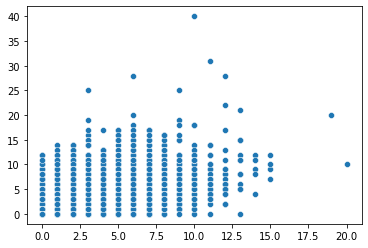

In [23]:
import seaborn as sns
sns.scatterplot(x=adata[:, "CD3E"].X.A.T[0], y=adata[:, "CD3D"].X.A.T[0])

### Задание

Возьмите значения столбца `nCount_RNA` из Seurat-объекта и добавьте его в объект `adata`.

In [24]:
%%R -o ncounts
ncounts <- seurat.obj[["nCount_RNA"]]

In [25]:
ncounts.index = [bc.split("-")[0] + ":don1" for bc in ncounts.index]

In [26]:
adata.obs["nCount_RNA"] = ncounts
adata.obs

,tissue,nCount_RNA
AAACCCAAGGCCCAAA:don1,PBMC,12143.0
AAACCCAAGTAATACG:don1,PBMC,7811.0
AAACCCAAGTCACACT:don1,PBMC,9741.0
AAACCCACAAAGCGTG:don1,PBMC,5561.0
AAACCCACAATCGAAA:don1,PBMC,7399.0
...,...,...
TTTGTTGGTTGGATCT:don1,PBMC,6199.0
TTTGTTGGTTTCTTAC:don1,PBMC,4658.0
TTTGTTGTCCATTTCA:don1,PBMC,5059.0
TTTGTTGTCTACACAG:don1,PBMC,5037.0


## SingleCellExperiment и anndata2ri

В дальнейшем удобно будет пользоваться тем, что существует пакет <code>anndata2ri</code>, который позволяет из окружения Python передать объект AnnData в окружение R, трансформировав его в объект класса SingleCellExperiment. В свою очередь объект класса SingleCellExperiment может быть легко трансформирован в Seurat.

In [27]:
%%R -i adata
adata

/usr/local/lib/python3.8/dist-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


class: SingleCellExperiment 
dim: 36601 11996 
metadata(0):
assays(1): X
rownames(36601): MIR1302-2HG FAM138A ... AC007325.4 AC007325.2
rowData names(2): gene_ids feature_types
colnames(11996): AAACCCAAGGCCCAAA:don1 AAACCCAAGTAATACG:don1 ...
  TTTGTTGTCTACACAG:don1 TTTGTTGTCTCATTAC:don1
colData names(2): tissue nCount_RNA
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [28]:
%%R
adata.to.seurat <- as.Seurat(adata, data = NULL, counts = "X")
adata.to.seurat

An object of class Seurat 
36601 features across 11996 samples within 1 assay 
Active assay: originalexp (36601 features, 0 variable features)


In [29]:
%R adata.to.seurat[[]]

,orig.ident,nCount_originalexp,nFeature_originalexp,tissue,nCount_RNA
AAACCCAAGGCCCAAA:don1,1,12143.0,3022,PBMC,12143.0
AAACCCAAGTAATACG:don1,1,7811.0,2667,PBMC,7811.0
AAACCCAAGTCACACT:don1,1,9741.0,2934,PBMC,9741.0
AAACCCACAAAGCGTG:don1,1,5561.0,1525,PBMC,5561.0
AAACCCACAATCGAAA:don1,1,7399.0,2078,PBMC,7399.0
...,...,...,...,...,...
TTTGTTGGTTGGATCT:don1,1,6199.0,1602,PBMC,6199.0
TTTGTTGGTTTCTTAC:don1,1,4658.0,1902,PBMC,4658.0
TTTGTTGTCCATTTCA:don1,1,5059.0,1551,PBMC,5059.0
TTTGTTGTCTACACAG:don1,1,5037.0,2194,PBMC,5037.0


### Задание

Попробуйте выбрать только те клетки, у которых в сумме больше, чем 10000 молекул, а также только те гены, которые экспрессируются более, чем в 3 клетках. Сделайте это как в Seurat, так и в scanpy, после чего обменяйте переменные в окружениях (например, <code>adata_filtered</code> переместите в окружение R и назовите его там <code>adata.to.Seurat.filtered</code>, и наоборот).

In [30]:
adata = adata[:, (adata.X > 0).sum(axis=0).A[0] > 3]
adata = adata[adata.X.sum(axis=1) > 10000]
adata

View of AnnData object with n_obs × n_vars = 2944 × 21460
    obs: 'tissue', 'nCount_RNA'
    var: 'gene_ids', 'feature_types'

In [31]:
%%R
seurat.filtered <- seurat.obj[rowSums(GetAssayData(object = seurat.obj, slot = "counts") > 0) > 3,]
seurat.filtered <- seurat.filtered[,colSums(GetAssayData(object = seurat.filtered, slot = "counts")) > 10000]
seurat.filtered

An object of class Seurat 
21460 features across 2944 samples within 1 assay 
Active assay: RNA (21460 features, 0 variable features)


In [32]:
%%R -o sce
sce <- as.SingleCellExperiment(seurat.filtered)

/usr/local/lib/python3.8/dist-packages/anndata2ri/r2py.py:106: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


## Домашнее задание

Сделайте несколько вспомогательных функций, которые вам позднее пригодятся:
1. Разбиение одного объекта AnnData на список других, соответствующих каждому индивидуальному батчу;
2. Создание нового объекта со случайными N клетками и M генами из изначального;
3. Сохранение вашего AnnData-объекта как Seurat-объекта в формате `.rds`.

# Задание 1
## Решение

Прочитаем содержимое отфильтрованной матрицы и создадим объект формата AnnData

In [41]:
anndata = sc.read_10x_mtx("filtered_feature_bc_matrix")
anndata.obs["tissue"] = "PBMC"

Создадим функцию, которая генерирует список батчей, состоящих из цифр.

Входные данные функции: количество клеток и размера батча.

In [88]:
def generate_batches_list(cells_number, batch_size):
  batches_list = []
  batches_number = cells_number // batch_size
  for i in range(batches_number):
    for _ in range(batch_size):
      batches_list.append(f'{i+1}')
  remainder = cells_number - (batch_size * batches_number)
  if remainder > 0:
    for _ in range(remainder):
      batches_list.append(f'{batches_number+1}')
  return batches_list

Создадим функцию, которая разделяет Anndata по батчам

In [89]:
def separate_by_batches(anndata, batch_size=2000):
  anndata_dict = {}
  anndata.obs["batch"] = generate_batches_list(anndata.shape[0], batch_size)
  batches = list(set(anndata.obs["batch"]))
  for batch in batches:
    anndata_dict[batch] = anndata[anndata.obs["batch"] == batch]
  return anndata_dict

separate_by_batches(anndata)

{'2': View of AnnData object with n_obs × n_vars = 2000 × 36601
     obs: 'tissue', 'batch'
     var: 'gene_ids', 'feature_types',
 '4': View of AnnData object with n_obs × n_vars = 2000 × 36601
     obs: 'tissue', 'batch'
     var: 'gene_ids', 'feature_types',
 '3': View of AnnData object with n_obs × n_vars = 2000 × 36601
     obs: 'tissue', 'batch'
     var: 'gene_ids', 'feature_types',
 '1': View of AnnData object with n_obs × n_vars = 2000 × 36601
     obs: 'tissue', 'batch'
     var: 'gene_ids', 'feature_types',
 '6': View of AnnData object with n_obs × n_vars = 1996 × 36601
     obs: 'tissue', 'batch'
     var: 'gene_ids', 'feature_types',
 '5': View of AnnData object with n_obs × n_vars = 2000 × 36601
     obs: 'tissue', 'batch'
     var: 'gene_ids', 'feature_types'}

# Задание 2
## Решение

Покажем, как выглядят данные баркодов клеток:

In [101]:
anndata.obs.index

Index(['AAACCCAAGGCCCAAA-1', 'AAACCCAAGTAATACG-1', 'AAACCCAAGTCACACT-1',
       'AAACCCACAAAGCGTG-1', 'AAACCCACAATCGAAA-1', 'AAACCCACAGATCACT-1',
       'AAACCCACATTGACCA-1', 'AAACCCAGTGAGCCAA-1', 'AAACCCAGTGATAGAT-1',
       'AAACCCAGTGCCTGAC-1',
       ...
       'TTTGTTGCATCACGGC-1', 'TTTGTTGCATCCAACA-1', 'TTTGTTGGTAAGGTCG-1',
       'TTTGTTGGTACAGAGC-1', 'TTTGTTGGTCGCAACC-1', 'TTTGTTGGTTGGATCT-1',
       'TTTGTTGGTTTCTTAC-1', 'TTTGTTGTCCATTTCA-1', 'TTTGTTGTCTACACAG-1',
       'TTTGTTGTCTCATTAC-1'],
      dtype='object', length=11996)

Вот так выглядят данные генов из AnnData файла:

In [102]:
anndata.var.index

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

Создадим функцию, которая генерирует случаным образом подмножество из данных генов и баркодов AnnData файла.

In [100]:
from random import choices

def generate_random_anndata_subset(anndata, cells_number, genes_number):
  random_cells_subset = choices(list(anndata.obs.index), k=cells_number)
  random_genes_subset = choices(list(anndata.var.index), k=genes_number)
  return anndata[random_cells_subset, random_genes_subset]

In [99]:
generate_random_anndata_subset(anndata, 2000 , 3000)

['ATCCTATGTTACGCCG-1', 'CTCCTCCAGGATGCGT-1', 'GTAAGTCAGAGTACCG-1', 'CAAGACTCAGAGCTAG-1', 'ATCGTCCCACATTGTG-1', 'GCAGGCTTCTGTGCAA-1', 'AGCGTATTCGAGTTGT-1', 'TGGTGATGTTCGGACC-1', 'CACCAAACATCGATCA-1', 'ACGTCCTGTCGCCACA-1', 'CACTGTCGTGTACGCC-1', 'TCCACCAAGTTGTCGT-1', 'GTCTTTAAGCGCATCC-1', 'AACCAACTCGACATAC-1', 'GATGTTGAGTAAAGCT-1', 'CAGGCCACAGTAACGG-1', 'TTCTGTAAGCCGCACT-1', 'GATCCCTGTTTGGGTT-1', 'CCTTCAGTCCTGCCAT-1', 'AACCTGATCTATGTGG-1', 'TCAGTCCGTCGCCACA-1', 'GTCCACTAGAGTTCGG-1', 'CATGGATGTAGGACTG-1', 'AGCGCTGTCGCGGTAC-1', 'GATAGAATCTATTGTC-1', 'TCTCACGCACAGTATC-1', 'CATCGTCTCGTGAGAG-1', 'CGAATTGGTAACAAGT-1', 'CAGATCAGTAACATGA-1', 'GCGAGAAGTCAGCTTA-1', 'GGGCCATGTTGCTCCT-1', 'CCACAAAAGCACTGGA-1', 'TATCTTGAGCGAATGC-1', 'CCGGTGACACGTCGTG-1', 'TAGGTTGGTGCGGATA-1', 'CATCGTCAGACCAACG-1', 'CAGTTAGGTTCTTGTT-1', 'ATGGGTTCATCCGGCA-1', 'CTGAATGCAAGAATGT-1', 'CCTCCTCGTGAGTTGG-1', 'TCGATTTAGCAGTACG-1', 'GGTCACGTCATACGGT-1', 'TTCTCTCGTAGTCGGA-1', 'ATCGTCCGTAGCACGA-1', 'CTCATGCCACCCTGAG-1', 'CAGATTGA

View of AnnData object with n_obs × n_vars = 2000 × 3000
    obs: 'tissue', 'batch'
    var: 'gene_ids', 'feature_types'

# Задание 3
## Решение

In [103]:
import anndata2ri
anndata2ri.activate()
%R .libPaths("usr/local/lib/R/site-library/")

'/content/...,'/usr/loca...,'/usr/lib/...,'/usr/lib/...


Напишем функцию, которая будет сохранять файл AnnData-объекта, как Seurat-объекта в формате `.rds`.

In [106]:
import rpy2.robjects as ro

def save_as_seurat(anndata, path = "./", name = 'out.rds'):
  ro.r("library(Seurat)")
  ro.globalenv["anndata"] = anndata
  ro.globalenv["path"] = path + name
  df = ro.r('out <- as.Seurat(anndata, data = NULL, counts = "X")')
  ro.r('saveRDS(out, file = path)')

In [107]:
save_as_seurat(anndata, name = 'anndata_as_seurat_out.rds')